In [27]:
import pandas as pd
import json

In [91]:
# plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

## Read Data

In [28]:
csv_file = 'data/EXPORT_09042017173622.csv'
json_file = 'data/gestures.json'

In [46]:
# Gesture List with names
with open(json_file) as data_file:    
    gestures = json.load(data_file)
    # j = json.loads(input_file.read().decode("utf-8-sig"))

In [45]:
gestures_df = pd.DataFrame.from_dict(gestures['gestures'])
gestures_df.set_index('id', inplace=True)
gestures_df

,$oid,isGarbage,isNesture,name,slug
id,,,,,
G01,58a23a22d826756404709446,NaN,NaN,Single Rotation klein rechtsrum,rssr
G02,58a23a22d826756404709447,NaN,NaN,Single Rotation klein linksrum,rssl
G03,58a23a22d826756404709448,NaN,NaN,Oszillierende Rotation klein rechtsrum,rosr
G04,58a23a22d826756404709449,NaN,NaN,Oszillierende Rotation klein linksrum,rosl
G05,58a23a22d82675640470944a,NaN,NaN,Single Rotation groß rechtsrum,rsbr
G06,58a23a22d82675640470944b,NaN,NaN,Single Rotation groß linksrum,rsbl
G07,58a23a22d82675640470944c,NaN,NaN,Oszillierende Rotation groß rechtsrum,robr
G08,58a23a22d82675640470944d,NaN,NaN,Oszillierende Rotation groß linksrum,robl
G09,58a23a22d82675640470944e,NaN,NaN,Kontinuierliche Rotation groß rechtsrum,rcbr


In [104]:
def gesture_name(gesture_id):
    return gestures_df.loc[gesture_id,'name']

In [2]:
# Experiment Data
data = pd.read_csv(csv_file)
data.shape

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2871: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [48]:
data.shape

(1435576, 26)

In [47]:
data.columns

Index([u'Trainset-ID', u'Experiment-ID', u'Subject-ID', u'Observer-ID',
       u'collectedByHand', u'Collector-ID', u'TimeStamp', u'RFID-ID',
       u'GRASP-A', u'GRASP-B', u'GRASP-C', u'AX', u'AY', u'AZ', u'EX', u'EY',
       u'EZ', u'USERINPUT', u'HANDINGLOVE', u' Parcours-ID', u'Parcours-Step',
       u'Mutation-ID', u' Mutation/HandIsActive', u'Host-ID', u'Host/Spot-ID',
       u'Gesture-ID'],
      dtype='object')

In [4]:
data.head()

,Trainset-ID,Experiment-ID,Subject-ID,Observer-ID,collectedByHand,Collector-ID,TimeStamp,RFID-ID,GRASP-A,GRASP-B,...,EZ,USERINPUT,HANDINGLOVE,Parcours-ID,Parcours-Step,Mutation-ID,Mutation/HandIsActive,Host-ID,Host/Spot-ID,Gesture-ID
0,_TRAINSET14022017094616,E001,Andreas,Clemens,right,R01,0,000000000000,781,8,...,-81.9375,False,True,P101,1,M151,True,H008,NaN,G15
1,_TRAINSET14022017094616,E001,Andreas,Clemens,left,L01,19896,000000000000,212,213,...,-84.5625,False,False,P101,1,M151,False,NaN,NaN,NaN
2,_TRAINSET14022017094616,E001,Andreas,Clemens,right,R01,29001,000000000000,782,0,...,-81.9375,False,True,P101,1,M151,True,H008,NaN,G15
3,_TRAINSET14022017094616,E001,Andreas,Clemens,left,L01,29823,000000000000,179,185,...,-84.5625,False,False,P101,1,M151,False,NaN,NaN,NaN
4,_TRAINSET14022017094616,E001,Andreas,Clemens,right,R01,46136,000000000000,782,6,...,-81.8750,False,True,P101,1,M151,True,H008,NaN,G15


## Some Data Stats

In [7]:
# how many subjects
data['Subject-ID'].unique().tolist()

['Andreas', 'Alfred', 'Claudia', 'Dominik']

In [8]:
# how many observers
data['Observer-ID'].unique().tolist()

['Clemens']

In [10]:
# how many hands
data['Collector-ID'].unique().tolist()

['R01', 'L01']

In [11]:
# how many RFID ids
data['RFID-ID'].unique().tolist()

['000000000000',
 '09006734114B',
 0,
 '05003DD5CD20',
 '760057911BAB',
 '13005E4BB7B1',
 '1400135B8AD6',
 '14001486BE38',
 '7600577D0D51',
 '140014CD1AD7',
 '280015E55981',
 '05008C2F993F']

In [9]:
# how many experiments
data['Experiment-ID'].unique().tolist()

['E001', 'E002', 'E003', 'E004', 'E005', 'E006', 'E007', 'E008']

In [24]:
# how many training sets
len(data['Trainset-ID'].unique().tolist())

539

In [17]:
# how many parcours
len(data[' Parcours-ID'].unique())

116

In [19]:
# how many parcours steps
data['Parcours-Step'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [20]:
# how many mutations
len(data['Mutation-ID'].unique())

177

In [21]:
# how many gestures
len(data['Gesture-ID'].unique())

19

In [22]:
# how many hosts
len(data['Host-ID'].unique())

10

## Data Preprocessing

In [ ]:
# rename some columns as the - in the column name does not allow for data.query()) to be used
# cut off the "-ID" suffix and replace - by _

for col in data.columns:
    if col.endswith('-ID'):
        data.rename(columns={col: col[:-3]}, inplace=True)
        print "Renamed", col, "->", col[:-3]
    elif '-' in col:
        new_col = col.replace('-','_')
        data.rename(columns={col: new_col}, inplace=True)
        print "Renamed", col, "->", new_col

In [82]:
data.rename(columns={'Experiment-ID': 'Experiment'}, inplace=True)  

In [53]:
# remove rows that are not needed:
# all where Gesture-ID is NaN  (implies 'Mutation/HandIsActive' == False and Host is NaN)

data.dropna(axis=0, subset=['Gesture-ID'], inplace=True)

In [67]:
# remove columns that we don#t need
# to be ignored as communicated by MOM
cols_to_remove = ['Trainset-ID','USERINPUT', 'HANDINGLOVE', 'Observer-ID','Collector-ID','Host/Spot-ID','RFID-ID',
                 ' Mutation/HandIsActive']
#TODO check Host/Spot-ID, Mutation
data.drop(cols_to_remove,inplace=True,axis=1)

In [68]:
data.shape

(780299, 18)

In [58]:
# also in this evaluation, we use only one-hand devices and only people who are right-handers
data['collectedByHand'].unique().tolist()

['right', 'left']

In [64]:
data['HANDINGLOVE'].unique().tolist()

[True, False]

In [60]:
sum(data['collectedByHand']=='right')

711360

In [59]:
# Q: keep left hand data or not?
sum(data['collectedByHand']=='left')
# TODO remove?

68939

In [ ]:
# filter right hand, throw away left hand


In [ ]:
# TODO check Mutation/HandIsActive -> filter out False!

## Look into the Data

In [76]:
data.head()

,Experiment-ID,Subject,collectedByHand,TimeStamp,GRASP-A,GRASP-B,GRASP-C,AX,AY,AZ,EX,EY,EZ,Parcours-ID,Parcours-Step,Mutation-ID,Host-ID,Gesture-ID
0,E001,Andreas,right,0,781,8,797,0.06,-0.02,-0.10,216.8125,9.0625,-81.9375,P101,1,M151,H008,G15
2,E001,Andreas,right,29001,782,0,799,0.09,-0.04,-0.11,217.0625,9.0625,-81.9375,P101,1,M151,H008,G15
4,E001,Andreas,right,46136,782,6,798,0.12,-0.09,0.09,217.4375,9.1250,-81.8750,P101,1,M151,H008,G15
6,E001,Andreas,right,74902,784,7,798,0.08,-0.08,0.03,217.6250,9.1250,-81.8125,P101,1,M151,H008,G15
8,E001,Andreas,right,97663,781,0,798,0.07,-0.09,0.04,217.9375,9.1875,-81.7500,P101,1,M151,H008,G15


In [92]:
exp = 'E001'
subject = 'Andreas'
gesture = 'G15'
mydata = data.query('Experiment==@exp and Subject==@subject and Gesture==@gesture')
mydata.shape

(17493, 18)

### Visualize timeline of sensor data

In [107]:
def myplot(var):
    y = mydata[var]
    x = range(len(y))
    plt.plot(x, y)
    title = "%s %s %s %s %s" % (exp,subject,gesture,gesture_name(gesture),var)
    plt.title(title)
    #plt.show()

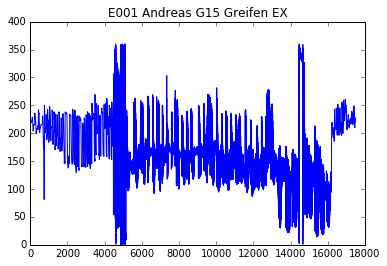

In [108]:
var = 'EX'
myplot(var)

In [ ]:
mydata

In [ ]:
# Standardize

In [ ]:
# Make groupings by Subject, Experiment, 

In [ ]:
# Calc derivatives

In [ ]:
# Time Normalize?

## Tasks

### 1) Recognize Host + Gesture

(maybe also Subject)

### 2) Recognize Gesture independent of host